# Tutorial 

This tutorial demonstrates the usage of the sweights package.

We will first cook up a toy model with a discriminat variable (invariant mass) and a control variable (decay time) and use it to generate some toy data.

Then we will use a fit to the invariant mass to obtain some component pdf estimates and use these to extract some weights which project out the signal only component in the decay time. 

We will demonstrate both the classic *sWeights* and the *Custom Ortogonal Weight functions* (COWs) method. See [arXiv:2112.04575](https://arxiv.org/abs/2112.04574) for more details.

Finally we will fit the weighted decay time distribution and correct the covariance matrix according to the description in [arXiv:1911.01303](https://arxiv.org/abs/1911.01303).

In [1]:
from types import SimpleNamespace

# external requirements
import numpy as np
from scipy.stats import norm, expon
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit.cost import ExtendedUnbinnedNLL

# from this package
from sweights import SWeight # for classic sweights
from sweights import Cow     # for custom orthogonal weight functions
from sweights import cov_correct, approx_cov_correct # for covariance corrections
from sweights.testing import make_classic_toy # to generate a toy dataset
from sweights.util import plot_binned     # to plot binned data

## Toy model and toy data

We generate an m-distribution (for the discriminatory variable) and an independent t-distribution (the control variable). In particle physics, m is typically the invariant mass distribution of decay candidates, and t is the decay time distribution of these candidates. But any other two variables can be used, as long as they are independent in the pure signal and pure background.

In [2]:
# make a toy model
true_yield = SimpleNamespace()
true_yield.s = 1000
true_yield.b = 1000

# mass
mrange = (0, 1)
m_truth = SimpleNamespace()
m_truth.mu = 0.5
m_truth.sigma = 0.1
m_truth.slope = 1

# time
trange = (0, 1.5)
t_truth = SimpleNamespace()
t_truth.slope = 0.2
t_truth.mu = 0.1
t_truth.sigma = 1.0

toy = make_classic_toy(
    1,
    s=true_yield.s,
    b=true_yield.b,
    mrange=mrange,
    trange=trange,
    ms_mu=m_truth.mu,
    ms_sigma=m_truth.sigma,
    mb_mu=m_truth.slope,
    ts_mu=t_truth.slope,
    tb_mu=t_truth.mu,
    tb_sigma=t_truth.sigma,
)

## Make pdfs, plot ground truth and toy data 

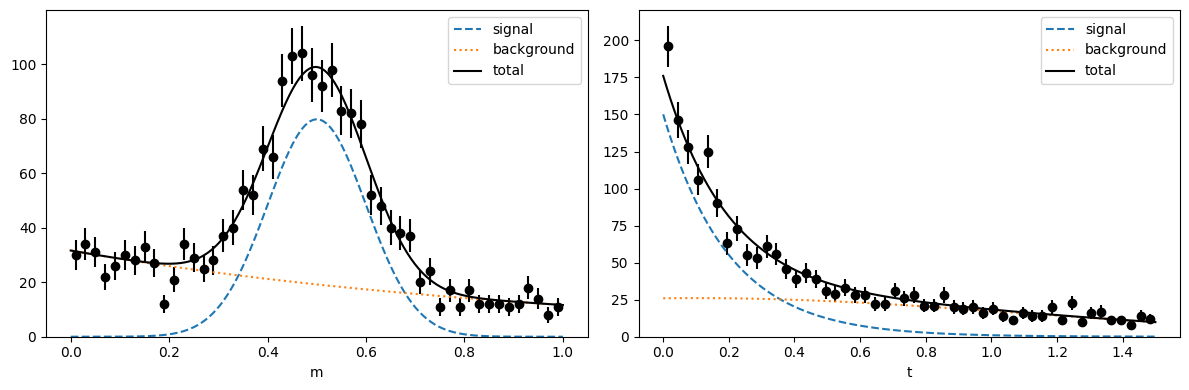

In [3]:
# m-density for fitting and plotting (not normalized)
def m_density(x, s, b, mu, sigma, slope):
    ds = norm(mu, sigma)
    snorm = np.diff(ds.cdf(mrange))

    db = expon(mrange[0], slope)
    bnorm = np.diff(db.cdf(mrange))

    return s / snorm * ds.pdf(x) + b / bnorm * db.pdf(x)


# t-density for fitting and plotting (not normalized)
def t_density(x, s, b, slope, mu, sigma):

    ds = expon(trange[0], slope)
    snorm = np.diff(ds.cdf(trange))

    db = norm(mu, sigma)
    bnorm = np.diff(db.cdf(trange))

    return s / snorm * ds.pdf(x) + b / bnorm * db.pdf(x)


def plot(toy, bins=50, npoint=400, draw_pdf=True):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    plt.sca(ax[0])
    plot_binned(toy[0], bins=bins, range=mrange, color="k")
    plt.sca(ax[1])
    plot_binned(toy[1], bins=bins, range=trange, color="k")

    if draw_pdf:
        m = np.linspace(*mrange, npoint)
        mnorm = (mrange[1] - mrange[0]) / bins

        par = m_truth.mu, m_truth.sigma, m_truth.slope
        s = m_density(m, true_yield.s, 0, *par)
        b = m_density(m, 0, true_yield.b, *par)
        p = s + b

        ax[0].plot(m, mnorm * s, "C0--", label="signal")
        ax[0].plot(m, mnorm * b, "C1:", label="background")
        ax[0].plot(m, mnorm * p, "k-", label="total")

        t = np.linspace(*trange, npoint)
        tnorm = (trange[1] - trange[0]) / bins

        par = t_truth.slope, t_truth.mu, t_truth.sigma
        s = t_density(t, true_yield.s, 0, *par)
        b = t_density(t, 0, true_yield.b, *par)
        p = s + b

        ax[1].plot(t, tnorm * s, "C0--", label="signal")
        ax[1].plot(t, tnorm * b, "C1:", label="background")
        ax[1].plot(t, tnorm * p, "k-", label="total")

    ax[0].set_xlabel("m")
    ax[0].set_ylim(bottom=0)
    ax[0].legend()

    ax[1].set_xlabel("t")
    ax[1].set_ylim(bottom=0)
    ax[1].legend()

    fig.tight_layout()


plot(toy)

In [4]:
# signal pdf in t-domain, need it for covariance correction
def t_signal_pdf(x, slope):
    return t_density(x, 1, 0, slope)

## Fit toy data in the m-variable

This provides us with estimates for the component shapes and the component yields, which we need to apply the sWeight method.

We use an extended unbinned maximum-likelihood fit here, but an extended binned maximum-likelihood fit would work as well. We could use an ordinary fit in which the model pdf is normalized.

In [5]:
# m-model for an extended maximum-likelihood fit, must return...
# - integral as first argument
# - density as second argument
# see iminuit documentation for more information
def m_model(x, s, b, mu, sigma, slope):
    return (s + b, m_density(x, s, b, mu, sigma, slope))


mi = Minuit(
    ExtendedUnbinnedNLL(toy[0], m_model),
    s=true_yield.s,
    b=true_yield.b,
    mu=m_truth.mu,
    sigma=m_truth.sigma,
    slope=m_truth.slope,
)
mi.limits["s", "b"] = (0, true_yield.s + true_yield.b)
mi.limits["mu"] = mrange
mi.limits["sigma"] = (0, mrange[1] - mrange[0])
mi.limits["slope"] = (0, 50)

mi.migrad()
mi.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = -2.705e+04                 │              Nfcn = 133              │
│ EDM = 9.21e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │  1.03e3   │  0.05e3   │            │            │    0    │  2000   │       │
│ 1 │ b     │    950    │    50     │            │            │    0    │  2000   │       │
│ 2 │ mu    │   0.498   │   0.004   │            │            │    0    │    1    │       │
│ 3 │ sigma │   0.099   │   0.004   │            │            │    0    │    1    │       │
│ 4 │ slope │   1.00    │   0.13    │            │            │    0    │   50    │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────────────────────────────────┐
│       │          s          b         mu      sigma      slope │
├───────┼────────────────────────────────────────────────────────┤
│     s │    2.2e+03     -1.2e3  -4.535e-3  89.181e-3     -1.170 │
│     b │     -1.2e3   2.11e+03   4.534e-3 -89.174e-3      1.170 │
│    mu │  -4.535e-3   4.534e-3   1.93e-05  -0.001e-3  -0.128e-3 │
│ sigma │  89.181e-3 -89.174e-3  -0.001e-3   1.75e-05  -0.087e-3 │
│ slope │     -1.170      1.170  -0.128e-3  -0.087e-3      0.016 │
└───────┴────────────────────────────────────────────────────────┘

### Compute sWeights

We first create an estimated pdfs of the signal and background component, respectively. Then we create the sWeighter object from the m-distribution, these pdfs, and the fitted yields.

Note that this will run much quicker if `verbose=False` and `checks=False`. 

In [6]:
def spdf(m):
    return m_density(m, 1, 0, *mi.values[2:])


def bpdf(m):
    return m_density(m, 0, 1, *mi.values[2:])


sweight = SWeight(
    toy[0],
    [spdf, bpdf],
    [mi.values["s"], mi.values["b"]],
    [mrange],
    method="summation",
    compnames=("sig", "bkg"),
    verbose=True,
    checks=True,
)

Initialising sweight with the summation method:
    PDF normalisations:
	 0 1.0
	 1 0.9999999999999999
    W-matrix:
	[[0.00069968 0.00029105]
	 [0.00029105 0.00073692]]
    A-matrix:
	[[1710.19413073 -675.44219476]
	 [-675.44219476 1623.76293684]]
    Integral of w*pdf matrix (should be close to the
                identity):
	[[ 1.00010800e+00  1.68040196e-06]
	 [-5.11035677e-05  9.99974569e-01]]
    Check of weight sums (should match yields):
	Component  | sWeightSum |   Yield    |   Diff    |
	---------------------------------------------------
	  0        |  1034.6386 |  1034.6386 |     0.00% |
	  1        |   948.3977 |   948.3977 |    -0.00% |


### Construct the COW

COW pdfs are weighted by a numerator, which we call the variance function $I(m)$. This function is arbitrary, but there is an optimal choice, which minimizes the variance of the weights. In case of factorizing signal and background PDFs, the optimal choice is $I(m) \propto g(m)$, where $g(m)$ is the estimated total density of in the discriminant variable m. But simply using $I(m) \propto 1$ gives almost equivalent results in this case. To use a constant density for $I(m)$, we pass `Im=None` to the `Cow` object.

In [7]:
# unity:
Im = None

# sweight equivalent:
# def Im(m):
#     return m_density(m, *mi.values) / (mi.values['s'] + mi.values['b'] )

# histogram:
# Im = np.histogram(toy[0], range=mrange)

# make the cow
cow = Cow(mrange, spdf, bpdf, Im, verbose=True)

Initialising COW:
    W-matrix:
	[[2.8365314  0.96600196]
	  [0.96600196 1.0827452 ]]
    A-matrix:
	[[ 0.50640982 -0.45180794]
	  [-0.45180794  1.32667165]]


## Comparison of the sweight and COW methods

We first compare the weight distributions.

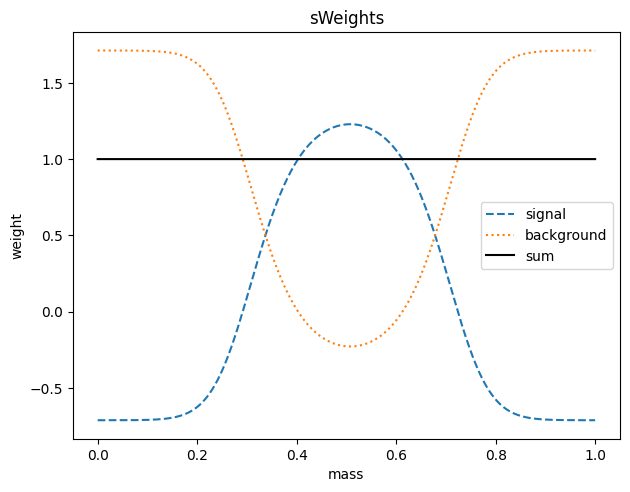

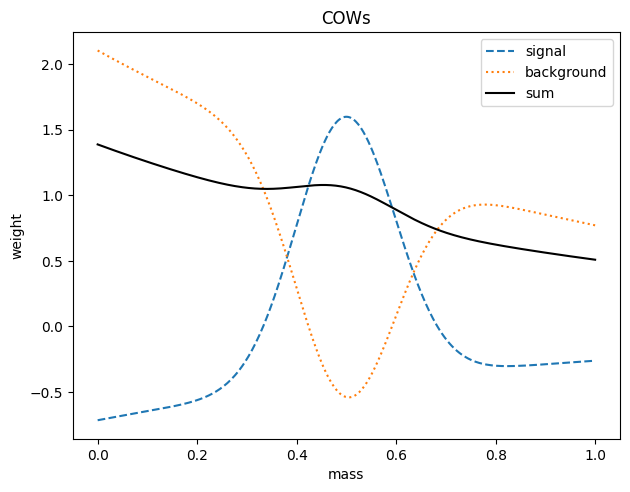

In [8]:
def plot_weights(x, sw, bw):
    plt.figure()
    plt.plot(x, sw, "C0--", label="signal")
    plt.plot(x, bw, "C1:", label="background")
    plt.plot(x, sw + bw, "k-", label="sum")
    plt.xlabel("mass")
    plt.ylabel("weight")
    plt.legend()
    plt.tight_layout()


for method, weighter in zip( ['sWeights','COWs'], [sweight, cow] ):
    x = np.linspace(*mrange,400)
    swp = weighter.get_weight(0, x)
    bwp = weighter.get_weight(1, x)
    plot_weights(x, swp, bwp)
    plt.title(method)

The weights are not identical, because in this case we used a simple (non-optimal) variance function for the COWs.

### Fit weighted t-distribution


In [9]:
# signal pdf in t-domain
def t_signal_pdf(x, slope):
    return t_density(x, 1, 0, slope, 0, 1)


# make weighted log-likelihood cost function for iminuit
def make_weighted_negative_log_likelihood(weights):
    def wnll(slope):
        p = t_signal_pdf(toy[1], slope)
        return -np.sum(weights * np.log(p))

    wnll.errordef = Minuit.LIKELIHOOD
    return wnll


fitted_slopes = []
for method, weighter in (("sWeights", sweight), ("COWs", cow)):

    # get signal weights
    w = weighter(toy[0])

    # do the minimisation
    tmi = Minuit(make_weighted_negative_log_likelihood(w), slope=t_truth.slope)
    tmi.limits["slope"] = (0, 10)
    tmi.migrad()
    tmi.hesse()

    # do the correction
    fitted_slopes.append(tmi.values["slope"])

    # first order correction
    ncov = approx_cov_correct(
        t_signal_pdf, toy[1], w, tmi.values, tmi.covariance, verbose=False
    )

    # second order correction
    hs = t_signal_pdf
    ws = weighter
    W = weighter.Wkl

    # these derivatives can be done numerically but for the sweights / COW case 
    # it's straightfoward to compute them
    ws = lambda Wss, Wsb, Wbb, gs, gb: (Wbb * gs - Wsb * gb) / (
        (Wbb - Wsb) * gs + (Wss - Wsb) * gb
    )
    dws_Wss = (
        lambda Wss, Wsb, Wbb, gs, gb: gb
        * (Wsb * gb - Wbb * gs)
        / (-Wss * gb + Wsb * gs + Wsb * gb - Wbb * gs) ** 2
    )
    dws_Wsb = (
        lambda Wss, Wsb, Wbb, gs, gb: (Wbb * gs**2 - Wss * gb**2)
        / (Wss * gb - Wsb * gs - Wsb * gb + Wbb * gs) ** 2
    )
    dws_Wbb = (
        lambda Wss, Wsb, Wbb, gs, gb: gs
        * (Wss * gb - Wsb * gs)
        / (-Wss * gb + Wsb * gs + Wsb * gb - Wbb * gs) ** 2
    )

    tcov = cov_correct(
        hs,
        [spdf, bpdf],
        toy[1],
        toy[0],
        w,
        [mi.values["s"], mi.values["b"]],
        tmi.values,
        tmi.covariance,
        [dws_Wss, dws_Wsb, dws_Wbb],
        [W[0, 0], W[0, 1], W[1, 1]],
        verbose=False,
    )
    print(
        f"{method:9}: "
        f"naive {tmi.values[0]:.3f} +/- {tmi.errors[0]:.3f}, "
        f"corrected {tmi.values[0]:.3f} +/- {tcov[0,0]**0.5:.3f}"
    )

sWeights : naive 0.217 +/- 0.007, corrected 0.217 +/- 0.017
COWs     : naive 0.218 +/- 0.007, corrected 0.218 +/- 0.017


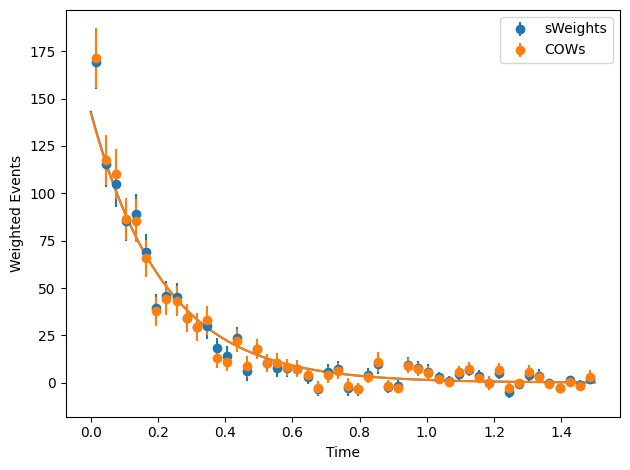

In [10]:
### Plot the weighted decay distributions and the fit result
sws = sweight.get_weight(0, toy[0])
scow = cow.get_weight(0, toy[0])

bins = 50
t = np.linspace(*trange, 400)

for i, (w, method, slope) in enumerate(
    zip(
        (sws, scow),
        ("sWeights", "COWs"),
        fitted_slopes,
    )
):
    color = f"C{i}"
    plot_binned(
        toy[1],
        bins=bins,
        range=trange,
        weights=w,
        label=method,
        color=color,
    )
    tnorm = np.sum(w) * (trange[1] - trange[0]) / bins
    plt.plot(t, tnorm * t_signal_pdf(t, slope), color=color)

plt.legend()
plt.xlabel("Time")
plt.ylabel("Weighted Events")
plt.tight_layout()

## Write sWeights into a file

There are many ways to store the sweights for later use. In the Python world, you can just pickle the arrays. Or you can use Numpy's npz format. A slightly more organized way is to use a Pandas data frame. We show that option.

In [11]:
import pandas as pd

df = pd.DataFrame()
df['m'] = toy[0]
df['t'] = toy[1]
df['sweight_ws'] = sweight.get_weight(0, toy[0])
df['sweight_wb'] = sweight.get_weight(1, toy[0])
df['cow_ws'] = cow.get_weight(0, toy[0])
df['cow_wb'] = cow.get_weight(1, toy[0])
df

,m,t,sweight_ws,sweight_wb,cow_ws,cow_wb
0,0.042040,1.376816,-0.712006,1.711925,-0.686494,2.015908
1,0.003055,0.719008,-0.712165,1.712084,-0.713967,2.096483
2,0.508762,0.072853,1.228738,-0.228663,1.589759,-0.540270
3,0.455855,0.255529,1.179151,-0.179080,1.404961,-0.327457
4,0.388724,0.034550,0.921604,0.078446,0.627698,0.430615
...,...,...,...,...,...,...
1978,0.739800,1.380903,-0.164694,1.164657,-0.235167,0.905985
1979,0.457037,0.553946,1.181472,-0.181400,1.414717,-0.337260
1980,0.054022,0.598493,-0.711867,1.711786,-0.678238,1.991748
1981,0.793120,0.850312,-0.547803,1.547735,-0.298025,0.925751


Pandas data frames can be saved in multiple formats (see Pandas documentation). The feather format is particularly good.

However, in the particle physics world, you probably want to save the table as a ROOT file. This is easy with uproot. It will convert the data frame into a ROOT TTree automatically.

In [12]:
import uproot

with uproot.recreate('outf.root') as f:
   f['tree'] = df